In [20]:
# imports
import torch
from torchvision import transforms

from torch.utils.data import DataLoader, Dataset
from pathlib import Path
from typing import Any, Callable, Iterable, Optional, Tuple, Union
import cv2
from PIL import Image

from accelerate import Accelerator
from tqdm import tqdm


In [3]:
def get_transform(name: str):
    if any(x in name for x in ('dino', 'mocov3', 'convnext', )):
        normalize = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        transform = transforms.Compose([transforms.ToTensor(), normalize])
    else:
        raise NotImplementedError()
    return transform

In [7]:
def get_model(name: str):
    if 'dinov2' in name:
        #  dinov2 models like dinov2_vits14
        model = torch.hub.load('facebookresearch/dinov2:main', name)
        model.fc = torch.nn.Identity()
        val_transform = get_transform(name)
        patch_size = model.patch_embed.patch_size
        num_heads = model.blocks[0].attn.num_heads
    elif 'dino' in name:
        model = torch.hub.load('facebookresearch/dino:main', name)
        model.fc = torch.nn.Identity()
        val_transform = get_transform(name)
        patch_size = model.patch_embed.patch_size
        num_heads = model.blocks[0].attn.num_heads
    else:
        raise ValueError(f'Cannot get model: {name}')
    model = model.eval()
    return model, val_transform, patch_size, num_heads

In [11]:
model_name = "dinov2_vits14"

In [12]:
model, val_transform, patch_size, num_heads = get_model(model_name)

Using cache found in C:\Users\Tmenova/.cache\torch\hub\facebookresearch_dinov2_main


In [78]:
patch_size

(14, 14)

In [13]:
which_block = -1
if 'dino' in model_name or 'mocov3' in model_name:
    feat_out = {}
    def hook_fn_forward_qkv(module, input, output):
        feat_out["qkv"] = output
    model._modules["blocks"][which_block]._modules["attn"]._modules["qkv"].register_forward_hook(hook_fn_forward_qkv)
else:
    raise ValueError(model_name)

In [15]:
class ImagesDataset(Dataset):
    """A very simple dataset for loading images."""

    def __init__(self, filenames: str, images_root: Optional[str] = None, transform: Optional[Callable] = None,
                 prepare_filenames: bool = True) -> None:
        self.root = None if images_root is None else Path(images_root)
        self.filenames = sorted(list(set(filenames))) if prepare_filenames else filenames
        self.transform = transform

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        path = self.filenames[index]
        full_path = Path(path) if self.root is None else self.root / path
        assert full_path.is_file(), f'Not a file: {full_path}'
        image = Image.open(full_path).convert('RGB')
        # image =  
        # image = cv2.imread(str(full_path))
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform is not None:
            image = self.transform(image)
        return image, path, index

    def __len__(self) -> int:
        return len(self.filenames)

In [16]:
images_list = "C:/Users/Tmenova/personal/tum/thesis/thesis-codebase/data/MINI/CAROTID_MIXED/val_mini/lists/images.txt"
images_root = "C:/Users/Tmenova/personal/tum/thesis/thesis-codebase/data/MINI/CAROTID_MIXED/val_mini/images"
filenames = Path(images_list).read_text().splitlines()
transform = transforms.Compose([transforms.ToTensor()])
dataset = ImagesDataset(filenames=filenames, images_root=images_root, transform=transform)

In [17]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, num_workers=0)


In [19]:
# Prepare
cpu = True
if torch.cuda.is_available():
    cpu = False
accelerator = Accelerator(cpu, mixed_precision="fp16")
# model, dataloader = accelerator.prepare(model, dataloader)
model = model.to(accelerator.device)
print('accelerator device=', accelerator.device)

accelerator device= cuda


In [21]:
pbar = tqdm(dataloader, desc='Processing')

Processing:   0%|          | 0/10 [00:00<?, ?it/s]

In [27]:
dataset[0]

(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0784, 0.0745, 0.0745],
          [0.0000, 0.0000, 0.0000,  ..., 0.0314, 0.0314, 0.0314],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0784, 0.0745, 0.0745],
          [0.0000, 0.0000, 0.0000,  ..., 0.0314, 0.0314, 0.0314],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0784, 0.0745, 0.0745],
          [0.0000, 0.0000, 0.0000,  ...,

In [33]:
images, files, indices = dataset[0]

In [41]:
batch = next(iter(dataset))

In [35]:
batch

(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0784, 0.0745, 0.0745],
          [0.0000, 0.0000, 0.0000,  ..., 0.0314, 0.0314, 0.0314],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0784, 0.0745, 0.0745],
          [0.0000, 0.0000, 0.0000,  ..., 0.0314, 0.0314, 0.0314],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0784, 0.0745, 0.0745],
          [0.0000, 0.0000, 0.0000,  ...,

In [36]:
images, files, indices = batch

In [46]:
pbar = tqdm(dataloader, desc='Processing')
print(dataloader)
for i, (images, files, indices) in enumerate(pbar):
    output_dict = {}
    # Reshape image
    P = patch_size[0]
    B, C, H, W = images.shape
    H_patch, W_patch = H // P, W // P
    H_pad, W_pad = H_patch * P, W_patch * P
    T = H_patch * W_patch + 1  # number of tokens, add 1 for [CLS]
    # images = F.interpolate(images, size=(H_pad, W_pad), mode='bilinear')  # resize image
    images = images[:, :, :H_pad, :W_pad]
    images = images.to(accelerator.device)

    # collect features
    if 'dinov2' in model_name or 'mocov3' in model_name:
        with torch.no_grad():
            # accelerator.unwrap_model(model).get_intermediate_layers(images)[0].squeeze(0)
            model.get_intermediate_layers(images)[0].squeeze(0)
        # output_dict['out'] = out
        output_qkv = feat_out["qkv"].reshape(B, T, 3, num_heads, -1 // num_heads).permute(2, 0, 3, 1, 4)
        output_dict['k'] = output_qkv[1].transpose(1, 2).reshape(B, T, -1)[:, 1:, :]
    else:
        raise ValueError(model_name)
    output_dict = {k: (v.detach().cpu() if torch.is_tensor(v) else v) for k, v in output_dict.items()}



Processing:   0%|          | 0/10 [00:00<?, ?it/s]

Processing: 100%|██████████| 10/10 [00:08<00:00,  1.15it/s]


In [47]:
output_dict

{'k': tensor([[[ 1.8729,  0.2479, -1.4329,  ...,  0.1663, -0.1796, -1.0883],
          [ 2.4307, -0.3700, -0.2780,  ...,  0.3730, -0.2587, -1.9577],
          [ 1.0429,  0.3578, -1.9638,  ...,  0.1203, -0.3740, -0.9415],
          ...,
          [ 2.0477,  0.8199, -1.6675,  ..., -0.0553, -1.1283, -2.5139],
          [ 1.9789,  0.3190, -0.7145,  ...,  0.3181, -0.6036, -0.5634],
          [ 1.6825,  0.9970, -1.1676,  ..., -0.0787, -0.8086, -1.7645]]])}

In [49]:
import torch.nn.functional as F


In [50]:
if torch.cuda.is_available():
    feats = output_dict["k"].squeeze().cuda()
else:
    feats = output_dict["k"].squeeze().cpu()

feats = F.normalize(feats, p=2, dim=-1)

In [51]:
n_clusters = 6


In [53]:
from sklearn.cluster import KMeans, MiniBatchKMeans


In [54]:
feats_numpy = feats.cpu().detach().numpy()
kmeans = KMeans(n_clusters=n_clusters, random_state=1)
clusters1 = kmeans.fit_predict(feats_numpy)

In [56]:
output_dict['indices'] = indices[0]
output_dict['file'] = files[0]
output_dict['id'] = id
output_dict['model_name'] = model_name
output_dict['patch_size'] = patch_size
output_dict['shape'] = (B, C, H, W)

In [60]:
import numpy as np

def get_segmap(clusters, data_dict):
    B, C, H, W, P, H_patch, W_patch, H_pad, W_pad = get_image_sizes(data_dict)
    # Reshape
    infer_bg_index = True
    if clusters.size == H_patch * W_patch:  # TODO: better solution might be to pass in patch index
        segmap = clusters.reshape(H_patch, W_patch)
    elif clusters.size == H_patch * W_patch * 4:
        segmap = clusters.reshape(H_patch * 2, W_patch * 2)
    else:
        raise ValueError()

    # TODO: Improve this step in the pipeline.
    # Background detection: we assume that the segment with the most border pixels is the 
    # background region. We will always make this region equal 0. 
    if infer_bg_index:
        indices, normlized_counts = get_border_fraction(segmap)
        bg_index = indices[np.argmax(normlized_counts)].item()
        bg_region = (segmap == bg_index)
        zero_region = (segmap == 0)
        segmap[bg_region] = 0
        segmap[zero_region] = bg_index

    return segmap

def get_image_sizes(data_dict: dict, downsample_factor = None):
    P = data_dict['patch_size'] if downsample_factor is None else downsample_factor
    P = P[0]
    B, C, H, W = data_dict['shape']
    assert B == 1, 'assumption violated :('
    H_patch, W_patch = H // P, W // P
    H_pad, W_pad = H_patch * P, W_patch * P
    return (B, C, H, W, P, H_patch, W_patch, H_pad, W_pad)

def get_border_fraction(segmap: np.array):
    num_border_pixels = 2 * (segmap.shape[0] + segmap.shape[1])
    counts_map = {idx: 0 for idx in np.unique(segmap)}
    np.zeros(len(np.unique(segmap)))
    for border in [segmap[:, 0], segmap[:, -1], segmap[0, :], segmap[-1, :]]:
        unique, counts = np.unique(border, return_counts=True)
        for idx, count in zip(unique.tolist(), counts.tolist()):
            counts_map[idx] += count
    # normlized_counts_map = {idx: count / num_border_pixels for idx, count in counts_map.items()}
    indices = np.array(list(counts_map.keys()))
    normlized_counts = np.array(list(counts_map.values())) / num_border_pixels
    return indices, normlized_counts

In [61]:
import matplotlib.pyplot as plt


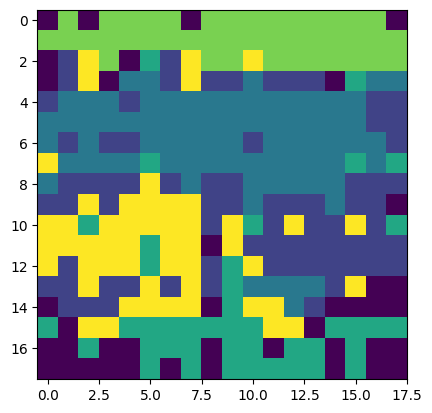

In [62]:
segmap_kmeans = get_segmap(clusters1, output_dict)
plt.imshow(segmap_kmeans)

## Test loading other dinov2 models

In [85]:
# model_name = "dino_vits8"
# model_name = "dino_vitb8"
# model_name = "dinov2_vits14"
model_name = "dinov2_vitb14"


model, val_transform, patch_size, num_heads = get_model(model_name)

Using cache found in C:\Users\Tmenova/.cache\torch\hub\facebookresearch_dinov2_main
